**Polytech Lyon - PTI - 5A GBM (30/09/2020)**

**Contents**: Nicolas Duchateau

***

Hands-on: classification from cardiac shape data
===

## Objectives

* Get used to Python and the **scikit-learn** tools for machine learning,
* Conduct a classification problem from **medical imaging data**, from data extraction and representation issues to the evaluation of a bench of machine learning algorithms.

## Overview

The dataset in **notebookData.mat** corresponds to 101 acquisitions from 2D echocardiography, post-processed using commercial 2D speckle-tracking software (Echopac v.110.1.2, GE Healthcare). It consists of the following:

* `shapeED` and `shapeES`: the **myocardial centerline at end-diastole and end-systole**, whose dimensions (101 x 2 x 67) stand for the number of subjects, the x-y coordinates, and the number of points along each curve,
* `labels`: the **subgroup** to which each subject belongs (either healthy volunteer or patient with hypertrophic cardiomyopathy),
* `HR`: the **heart rate** of each acquisition,
* `sysDuration`: the relative **duration of systole** vs. the whole cycle (in %)

30 subjects have masked labels (`NaN` values) and will serve as testing set.
**This exercise aims at predicting their labels from the remaining subjects' data,** by first running classification algorithms on 2 and 12 hand-crafted features extracted from the data, and then on the whole initial data without extracting features.

>**Note**: Before you begin, you should make sure that the data from **notebookData.mat** are correctly loaded.

In [2]:
import scipy.io as sio
import numpy as np

fileName = "./notebookData.mat"

mat_contents = sio.loadmat(fileName)
mat_contents.keys()
if len(mat_contents.keys()) != 9:
    raise Exception('Error in loading data')
else:
    print('Data correctly loaded !')
    
labels = mat_contents['labels']-1
labels = np.where(np.isnan(labels),2,labels)
shapeED = mat_contents['shapeED']
shapeES = mat_contents['shapeES']
HR = mat_contents['HR']
sysDuration = mat_contents['sysDuration']
unknownLABELS = mat_contents['unknownLABELS']-1

Data correctly loaded !


## Part 1: Data display and features computation

The dataset consists of myocardial delineations of the left ventricle, obtained from echocardiography using speckle-tracking, cf. animated gif below:

<img src="HCM.gif" style="height: 400px;"/><img src="Myocardium-02.png" style="height: 300px;"/>

### Q1.1 
Let's first plot the **shapes in each subgroup at end-diastole** (beginning of the cycle) and **end-systole** (end of the contraction).

In [3]:
import matplotlib.pyplot as plt

numCases,_,numCP = shapeES.shape
numGroups = 3
apex = 31 ### apex location along the shape, not exactly math.floor(numCP / 2)

colorT = ['b','r','k']
fig,sub = plt.subplots(2,numGroups,figsize=(10,10))

plt.subplots_adjust(wspace=0.25, hspace=0.1)
for phasei, phase in enumerate(['ED','ES']):
    for sbi in range(0,numGroups):
        ax = sub[phasei,sbi]
        idx = np.argwhere( labels == sbi )[:,0]
        if phasei==0:
            tmp = np.transpose( shapeED[idx,:,:] , axes=(2,0,1) )
        else:
            tmp = np.transpose( shapeES[idx,:,:] , (2,0,1) )
        ax.plot(tmp[:,:,0],tmp[:,:,1],color=colorT[sbi],alpha=0.2)
        ax.plot(tmp[apex,:,0],tmp[apex,:,1],'k.')
        ax.set_aspect('equal')
        ax.set_xlim(-30,60)
        ax.set_ylim(0,130)
        ax.grid()
        ax.set_title('subgroup ' + str(sbi+1) + ' - ' + phase)
plt.show()

<Figure size 1000x1000 with 6 Axes>

Observe the shape data: do you already have the intuition of some subgroup differences? Which features would you consider relevant to compute, given such shapes?

<span style="color:blue">

Comment : Healthy dataset blue / Pathological dataset red / Test dataset black

* Curavture more important close to the apex (black dots) pathological case
* Distribution of the apex pathological case
* Difference of length (Vertical axis) between ED and ES: heathly group 120 to 100, pathological group 100 to 100
</span>

### Q1.2

The following code computes **12 hand-crafted features** from these shapes.

In [4]:
def PolyArea(x,y):
    """Compute polygon area using the Shoelace formula
    Equivalent to Matlab polyarea function
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

features = np.zeros((numCases,12))

shapeArea = np.zeros((numCases,2))
apexCurvature = np.zeros((numCases,2))
septalCurvature = np.zeros((numCases,2))
localLength = np.zeros((numCases,numCP-1,2))

for phasei, phase in enumerate(['ED','ES']):
    for k in range(0,numCases):        
        if phasei==0:
            tmp = shapeED[k,:,:]
        else:
            tmp = shapeES[k,:,:]
        
        ### myocardial length
        tmpD = tmp[:,1:] - tmp[:,:-1]
        tmpD = ( np.sum(tmpD**2,0) )**(1/2)
        localLength[k,:,phasei] = tmpD
        
        ### features 0 & 1
        tmpD = np.sum(tmpD)
        features[k,phasei] = tmpD

        ### features 2 & 3
        tmpA = PolyArea(tmp[0,:],tmp[1,:])
        features[k,phasei+2] = tmpA
        
        ### first derivative = tangent vector T
        tmpD = tmp[:,1:] - tmp[:,:-1]
        ### normalize it
        tmpNorm = ( np.sum(tmpD**2,0) )**(1/2)
        tmpD = np.divide( tmpD,np.tile(tmpNorm,(2,1)) )
        ### second derivative = dT/ds
        tmpD2 = tmpD[:,1:] - tmpD[:,:-1]
        tmpNorm2 = ( np.sum(tmpD2**2,0) )**(1/2)
        
        ### features 6 & 7
        features[k,phasei+6] = tmpNorm2[apex]
        ### features 8 & 9
        features[k,phasei+8] = np.mean(tmpNorm2[1:(apex-10)])
        
### feature 4
tmpS = np.divide( localLength[:,:,1] - localLength[:,:,0] , localLength[:,:,1] )
features[:,4] = np.mean( tmpS , 1 )
### feature 5
features[:,5] = np.divide( features[:,3] - features[:,2] , features[:,2] )
### features 10 & 11
features[:,10] = [x for x in sysDuration]
features[:,11] = [x for x in HR]


Can you understand the meaning of each feature? How relevant do you think they are given the shapes observed before?

<span style="color:blue">
Based on the previous observation, the length features and the curvature should be relevant for our population
</span>

Fill in the following code with the features you have identified:

In [5]:
### SOLUTION

names = [
        'FEATURE 0 = total length ED',
        'FEATURE 1 = total length ES',
        'FEATURE 2 = area ED',
        'FEATURE 3 = area ES',
        'FEATURE 4 = global longitudinal strain',
        'FEATURE 5 = area change',
        'FEATURE 6 = apex curvature ED',
        'FEATURE 7 = apex curvature ES',
        'FEATURE 8 = septal curvature ED',
        'FEATURE 9 = septal curvature ES',
        'FEATURE 10 = systolic duration',
        'FEATURE 11 = heart rate'
        ]

### Q1.3

We can then plot the **distribution of these features across the subgroups**.

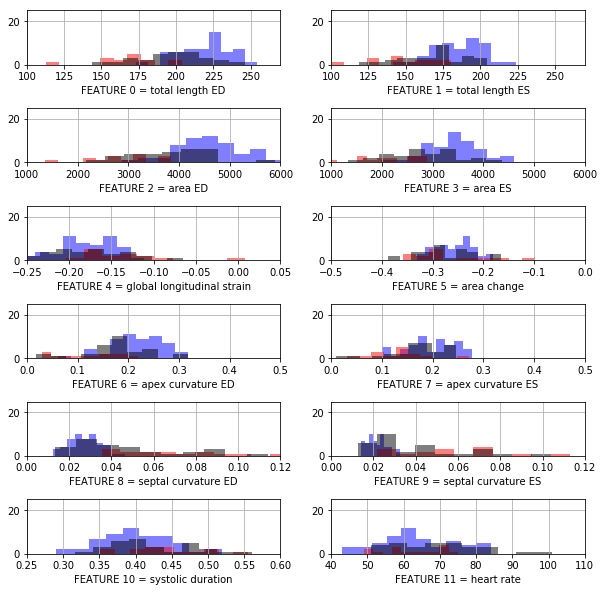

In [6]:
axisT = np.zeros((4,12))
axisTop = 25
axisT[:,0] = [100,270,0,axisTop]
axisT[:,1] = [100,270,0,axisTop]
axisT[:,2] = [1000,6000,0,axisTop]
axisT[:,3] = [1000,6000,0,axisTop]
axisT[:,4] = [-0.25,0.05,0,axisTop]
axisT[:,5] = [-0.5,0,0,axisTop]
axisT[:,6] = [0,0.5,0,axisTop]
axisT[:,7] = [0,0.5,0,axisTop]
axisT[:,8] = [0,0.12,0,axisTop]
axisT[:,9] = [0,0.12,0,axisTop]
axisT[:,10] = [0.25,0.6,0,axisTop]
axisT[:,11] = [40,110,0,axisTop]

fig,sub = plt.subplots(6,2,figsize=(10,10))
plt.subplots_adjust(wspace=0.2, hspace=0.8)
for fi in range(0,12):
    for sbi in range(0,numGroups):
        ax = sub.flatten()[fi]
        tmp = features[:,fi]
        idx = np.argwhere( labels == sbi )[:,0]
        nb,xb = np.histogram(tmp[idx],10)
        ax.hist(tmp[idx], bins=10, density=False, alpha=0.5, histtype='stepfilled', color=colorT[sbi], edgecolor='none')
        ax.grid()
        ax.set_xlim(axisT[0,fi],axisT[1,fi])
        ax.set_ylim(axisT[2,fi],axisT[3,fi])
        ax.set_xlabel(names[fi])
plt.show()

Are some features more discriminative than others? Does this confirm your previous observations on shapes? How challenging is the dataset for the masked subjects?

<span style="color:blue">
Comment: Looking for which features separate well the blue and the red histogramm (representing our train dataset)

Our previous hypothesis seems to be correct
The length and the curvature feature are well discriminative
</span>

## Part 2: SVM classification using 2 features

### Q2.1 
The following code launches a **linear SVM classifier on the features #0 and #9**. The code should plot the training and testing samples, and the decision boundary. Use this to understand the influence of the hyper-parameter `c` and determine which relevant value to use for it.

In [7]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

#########################################
### YOUR TESTS HERE
models = [SVC(kernel='linear', C=1.0)]
#########################################

names = ['Linear SVM']

featureUsed = [0,9]

idx = np.argwhere( labels < 2 )[:,0]
Xtrain = features[idx,:][:,featureUsed]
sc = StandardScaler().fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Ytrain = labels[idx].ravel()

idx = np.argwhere( labels == 2 )[:,0]
Xtest = features[idx,:][:,featureUsed]
Xtest = sc.transform(Xtest)
Ytest = unknownLABELS.ravel()

models = [clf.fit(Xtrain,Ytrain) for clf in models]

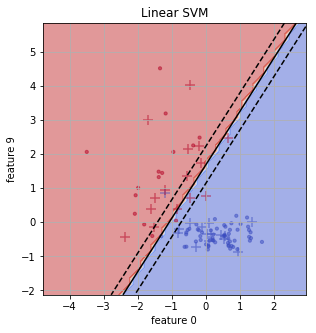

In [12]:
### 2D visualization

def make_meshgrid(x, y, h=.02):
    deltax = x.max() - x.min()
    deltay = y.max() - y.min()
    m = 0.25
    x_min, x_max = x.min() - m*deltax, x.max() + m*deltax
    y_min, y_max = y.min() - m*deltay, y.max() + m*deltay
    xx,yy = np.mgrid[x_min:x_max:50j, y_min:y_max:50j]
    return xx, yy

def visualizeOutput(models,Xtrain,Ytrain,Xtest,Ytest):
    xx, yy = make_meshgrid(Xtrain[:,0],Xtrain[:,1])
    
    fig,sub = plt.subplots(1,len(models),figsize=(5*len(models),5))
    
    if len(models)==1:
        sub = [sub]
    
    for clf, title, ax in zip(models, names, sub):

        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            Zc = 0
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]    
            Zc = 0.5
        Z = Z.reshape(xx.shape)
        ax.contour(xx,yy,Z,colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
        ax.contourf(xx,yy,Z>Zc,10,cmap=plt.cm.coolwarm,alpha=0.5)

#        To visualize the decision function
#        ax.contourf(xx,yy,Z,10,cmap=plt.cm.coolwarm,alpha=0.5)

        ax.scatter(Xtrain[:,0],Xtrain[:,1], c=Ytrain, cmap=plt.cm.coolwarm, s=10,alpha=0.5)
        ax.scatter(Xtest[:,0],Xtest[:,1],c=Ytest,cmap=plt.cm.coolwarm,marker='+',s=100,alpha=0.5)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_aspect('equal')
        ax.grid()
        ax.set_xlabel('feature '+str(featureUsed[0]))
        ax.set_ylabel('feature '+str(featureUsed[1]))
        ax.set_title(title)
    plt.show()
    
visualizeOutput(models,Xtrain,Ytrain,Xtest,Ytest)

Comment: 
We are trying to test the influence of the parameters C. 
It is easy to see that C influence the size of the margin. 

Reminder, here we try to choose the best parameters C for our train dataset. In the figure, it is impoortant to look at the dots which represent the train dataset. The goal is to have all the blue dots in the blue background, same for the red one (be careful of the overfitting)

You can't fint the optimal C value just by qualitative observation, we will try in the next step method to find the optimum parameters

### Q2.2
Fill in the following code to launch a **kernel RBF SVM classifier** (non-linear decision boundary) on the same two features. Use the same strategy to understand the influence of the hyper-parameters `c` and `gamma`. Why is this model more appropriate?

<span style="color:blue">
In the kernel RBF svm classifier, there is a new hyperparameter gamma.
The parameter gamma define the zone of influence of single training example. For a low value, the zone of influence will be large, and for high value, it will be close. 

At gamma = 20, the zone of influence is very small. The algorithm separates individually some training sample => overfitting
</span>

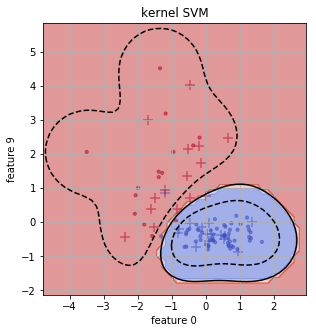

In [15]:
#########################################
### SOLUTION
models = [SVC(kernel='rbf', C=1.0 ,gamma=1)]
#########################################

names = ['kernel SVM']

models = [clf.fit(Xtrain,Ytrain) for clf in models]

visualizeOutput(models,Xtrain,Ytrain,Xtest,Ytest)

### Q2.3 (Optionnal)
Use **cross-validation** with `GridSearchCV` to automatically determine the best hyper-parameters to use.

{'C': 1, 'gamma': 0.1}


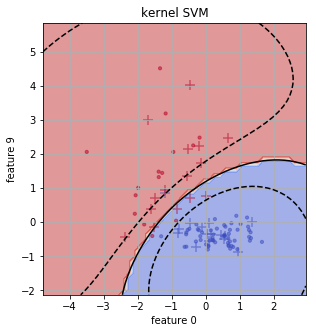

In [16]:
#########################################
### SOLUTION
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

best_params_ = svc_param_selection(Xtrain, Ytrain, 5)
print(best_params_)
    
C_best = best_params_['C']
gamma_best = best_params_['gamma']
#########################################

models = [SVC(kernel='rbf', C=C_best ,gamma=gamma_best)]
names = ['kernel SVM']

models = [clf.fit(Xtrain,Ytrain) for clf in models]

visualizeOutput(models,Xtrain,Ytrain,Xtest,Ytest)

<span style="color:blue">
Important to choose a good range of value for your parameters
Try first to find the order of matgnitude and then try other value in the same order of magnitude
</span>

### Q2.4
Extend your analysis to **other classification algorithms**: SVM polynomial (degree 3), nearest neighbors (`KNeighborsClassifier`), random forests (`RandomForestsClassifier`), neural network (`MLPClassifier`), etc.

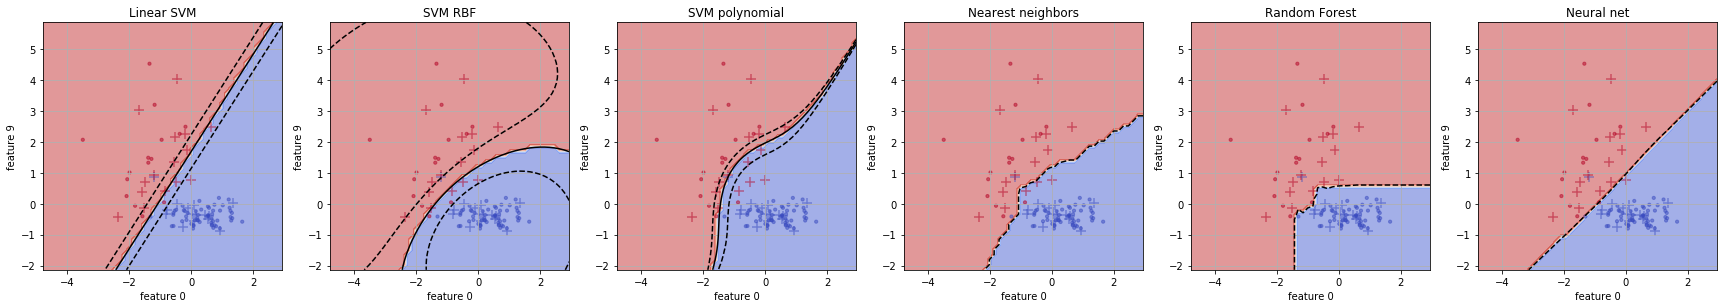

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

#########################################
### SOLUTION
models = [
    SVC(kernel='linear', C=1.0),
    SVC(kernel='rbf',gamma=0.1,C=1.0),
    SVC(kernel='poly',degree=3,C=1.0),
    KNeighborsClassifier(3),
    RandomForestClassifier(max_depth=3, n_estimators=100, max_features='auto'),
    MLPClassifier(alpha=0.1,max_iter=1000)]
#########################################

names = (
        'Linear SVM',
        'SVM RBF',
        'SVM polynomial',
        'Nearest neighbors',
        'Random Forest',
        'Neural net')

models = [clf.fit(Xtrain,Ytrain) for clf in models]

visualizeOutput(models,Xtrain,Ytrain,Xtest,Ytest)

Neural net and random forest seem to be the better classifier for this example.

To compare the different classifiers, you can only use observations here. Some score, like accuracy, will be used next to compare them and to be raelly able to compare them each other.

### Q2.5
Fill in the following code to **evaluate the performance of the algorithms and visualize it**. What do you think?

<span style="color:blue">Globally, the result are really close. But, random forest has a better accuracy and precision/recall</span>

In [18]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

class LearningResults:
    def __init__(self):
        self.Ypred = []
        self.acc_test = []
        self.recall = []
        self.precision = []
        self.strategy = []
        self.names = []
    def __add__(s, o):
        self = LearningResults()
        for z in (s,o):
            for Ypred,acc_test,recall,precision,strategy,names in zip(z.Ypred,z.acc_test,z.recall,z.precision,z.strategy,z.names):
                self.Ypred.append(Ypred)
                self.acc_test.append(acc_test)
                self.recall.append(recall)
                self.precision.append(precision)
                self.strategy.append(strategy)
                self.names.append(names)
        return self

def computePerformance(models,Xtrain,Ytrain,Xtest,Ytest,strategy,names):
    """Compute classifier performance and append to existing data
    """
    scoring = ['accuracy','precision','recall']
    results = LearningResults()
        
    for clf,n in zip(models,names):
        
        #########################################
        ### SOLUTION        
        clf.fit(Xtrain,Ytrain)
        Ypred = clf.predict(Xtest)
        #########################################

        Ypred = np.around( Ypred )
        results.Ypred.append( Ypred )
        results.acc_test.append( accuracy_score(Ytest,Ypred) )
        results.recall.append( recall_score(Ytest,Ypred) )
        results.precision.append( precision_score(Ytest,Ypred) )
        results.strategy.append( strategy )
        results.names.append( n )
        
    return results

results_2F = computePerformance(models,Xtrain,Ytrain,Xtest,Ytest,'2F',names)

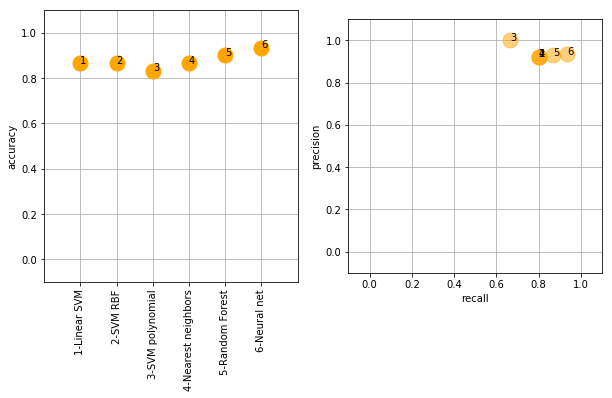

In [19]:
def plotPerformance(results):
    
    colorT = {'2F': 'orange', '12F': 'green', 'PLS': 'red' }

    fig,sub = plt.subplots(1,2,figsize=(10,5))
    
    N = len(results.names)
    
    ax = sub[0] ### accuracy (train,test)
    for i in range(0,N):
        ax.plot(i+1,results.acc_test[i],'.',color=colorT[results.strategy[i]],markersize=30)
        ax.text(i+1,results.acc_test[i],str(i+1),color='k')
    ax.set_xticks([i+1 for i in range(0,N)])
    xtick = [str(i+1)+'-'+n for i,n in zip(range(0,N),results.names)]
    ax.set_xticklabels(xtick,rotation=90)
    ax.set_xlim(0,N+1)
    ax.set_ylim(-0.1,1.1)
    ax.grid()
    ax.set_ylabel('accuracy')

    ax = sub[1] ### precision-recall (test)
    for i,st,x,y in zip(range(0,N),results.strategy,results.recall,results.precision):
        ax.plot(x,y,'.',alpha=0.5,markersize=30,color=colorT[st])
        ax.text(x,y,str(i+1),color='k')
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.1,1.1)
    ax.set_aspect('equal')
    ax.grid()
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')

    plt.show()

plotPerformance(results_2F)

## Part 3: SVM classification using more features

### Q3.1
Fill in the following code to **use more than 2 input features**. Would you use all of them? What would be your selection strategy?

In [20]:
#########################################
### SOLUTION
featureUsed = range(0,12)
#########################################

idx = np.argwhere( labels < 2 )[:,0]
Xtrain = features[idx,:][:,featureUsed]
sc = StandardScaler().fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Ytrain = labels[idx].ravel()

idx = np.argwhere( labels == 2 )[:,0]
Xtest = features[idx,:][:,featureUsed]
Xtest = sc.transform(Xtest)
Ytest = unknownLABELS.ravel()

results_12F = computePerformance(models,Xtrain,Ytrain,Xtest,Ytest,'12F',names)

### Q3.2
Visualize the results for this new strategy: what do you think?

Using 12 features here not seem to imoprve our result. Some of the features wasn't disciminative for our population and can affect the performance of our classifier

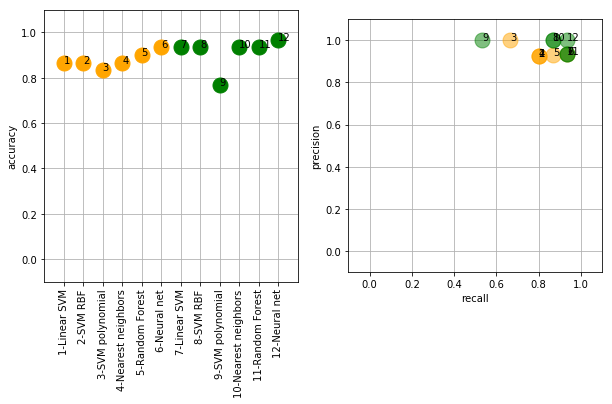

In [21]:
results = results_2F + results_12F
plotPerformance(results)

### Q3.3
Fill in the code to perform **ensemble learning by averaging the predictions of all the classifiers**, either on 2 features or on all features. Is performance improved?

<span style="color:blue">Ensemble learning not seem to improve the performance of the classifier</span>

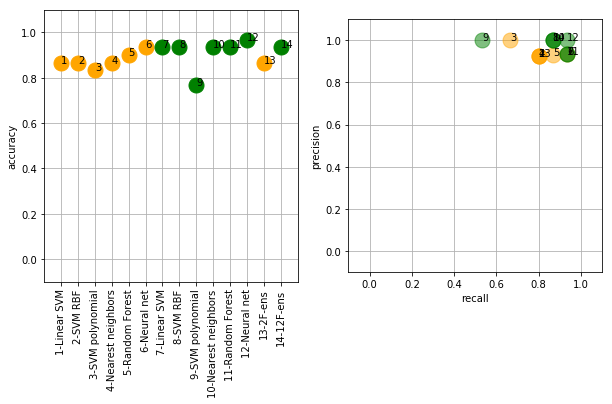

In [22]:
#########################################
### SOLUTION
Yall = np.zeros((len(Ytest),6))
for sti,Ypred in enumerate(results_2F.Ypred):
    Yall[:,sti] = Ypred
Ypred = np.around( np.mean(Yall,1) )
#########################################

results_ENS = LearningResults()

results_ENS.Ypred.append( Ypred )
results_ENS.acc_test.append( accuracy_score(Ytest,Ypred) )
results_ENS.recall.append( recall_score(Ytest,Ypred) )
results_ENS.precision.append( precision_score(Ytest,Ypred) )
results_ENS.strategy.append('2F')
results_ENS.names.append('2F-ens')

#########################################
### SOLUTION
Yall = np.zeros((len(Ytest),6))
for sti,Ypred in enumerate(results_12F.Ypred):
    Yall[:,sti] = Ypred
Ypred = np.around( np.mean(Yall,1) )
#########################################

results_ENS.Ypred.append( Ypred )
results_ENS.acc_test.append( accuracy_score(Ytest,Ypred) )
results_ENS.recall.append( recall_score(Ytest,Ypred) )
results_ENS.precision.append( precision_score(Ytest,Ypred) )
results_ENS.strategy.append('12F')
results_ENS.names.append('12F-ens')

results = results_2F + results_12F + results_ENS
plotPerformance(results)

## Part 4: Broader view on the problem

### Q4.1
**PLS regression** can perform the classification **directly from the shape coordinates**, without the hand-crafted features used until now. Fill in the following code to add this method to your evaluation. How does it compare to your previous results?

<span style="color:blue">
PLS obtain better accuracy and precison/recall score than the other method.
This problem wasn't a complex problem. A classic method, like PLS can obtain better results by just using 3D coordinate without extracting fetaures. 
</span>


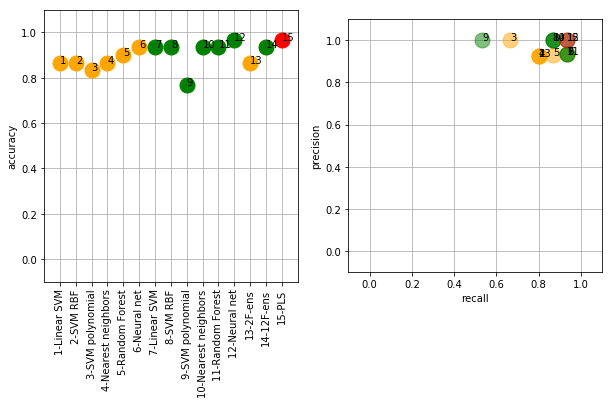

In [23]:
from sklearn.cross_decomposition import PLSRegression

#########################################
### SOLUTION
idx = np.argwhere( labels < 2 )[:,0]
tmp = shapeED[idx,:,:]
Xtrain = np.reshape(tmp,(tmp.shape[0],tmp.shape[1]*tmp.shape[2]))
Ytrain = labels[idx].ravel()

idx = np.argwhere( labels == 2 )[:,0]
tmp = shapeED[idx,:,:]
Xtest = np.reshape(tmp,(tmp.shape[0],tmp.shape[1]*tmp.shape[2]))
Ytest = unknownLABELS.ravel()

models = [ PLSRegression(n_components=10) ]
#########################################

results_PLS = computePerformance(models,Xtrain,Ytrain,Xtest,Ytest,'PLS',['PLS'])

results = results_2F + results_12F + results_ENS + results_PLS
plotPerformance(results)


### Q4.2
Look back at the distribution of the shapes and of each computed feature. What are your **conclusions on the difficulty of the problem?** You may examine the mispredicted cases to complement your opinion.

Mispredicted Healthy: 
[]
Mispredicted HCM: 
[20]


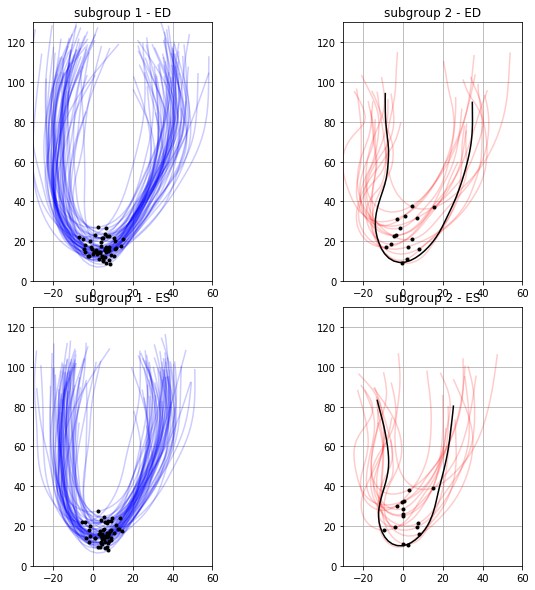

In [24]:
#########################################
### SOLUTION

idxMODEL = 6 ### model to test

models = [
    SVC(kernel='linear', C=1.0),
    SVC(kernel='rbf',gamma=0.1,C=1.0),
    SVC(kernel='poly',degree=3,C=1.0),
    KNeighborsClassifier(3),
    RandomForestClassifier(max_depth=3, n_estimators=100, max_features='auto'),
    MLPClassifier(alpha=0.1,max_iter=1000),
    PLSRegression(n_components=10)]

if idxMODEL < 6:
    featureUsed = range(0,12)
    idx = np.argwhere( labels < 2 )[:,0]
    Xtrain = features[idx,:][:,featureUsed]
    sc = StandardScaler().fit(Xtrain)
    Xtrain = sc.transform(Xtrain)
    Ytrain = labels[idx].ravel()
    idx = np.argwhere( labels == 2 )[:,0]
    Xtest = features[idx,:][:,featureUsed]
    Xtest = sc.transform(Xtest)
    Ytest = unknownLABELS.ravel()
else:
    idx = np.argwhere( labels < 2 )[:,0]
    tmp = shapeED[idx,:,:]
    Xtrain = np.reshape(tmp,(tmp.shape[0],tmp.shape[1]*tmp.shape[2]))
    Ytrain = labels[idx].ravel()
    idx = np.argwhere( labels == 2 )[:,0]
    tmp = shapeED[idx,:,:]
    Xtest = np.reshape(tmp,(tmp.shape[0],tmp.shape[1]*tmp.shape[2]))
    Ytest = unknownLABELS.ravel()

clf = models[idxMODEL]
clf.fit(Xtrain,Ytrain)
Ypred = clf.predict(Xtest)
Ypred = np.around( Ypred ).ravel()
Ypred = [int(y) for y in Ypred]

tmp = Ypred - Ytest
idx_H = np.argwhere( tmp > 0 )[:,0] ### Healthy predicted as HCM
idx_P = np.argwhere( tmp < 0 )[:,0] ### HCM predicted as Healthy

print("Mispredicted Healthy: ")
print(idx_H)
print("Mispredicted HCM: ")
print(idx_P)

colorT = ['b','r','k']
fig,sub = plt.subplots(2,numGroups-1,figsize=(10,10))

plt.subplots_adjust(wspace=0.25, hspace=0.1)
for phasei, phase in enumerate(['ED','ES']):
    for sbi in range(0,numGroups-1):
        ax = sub[phasei,sbi]
        idx = np.argwhere( labels == sbi )[:,0]
        idxUNKNOWN = np.argwhere( labels == 2 )[:,0]
        if phasei==0:
            tmp = np.transpose( shapeED[idx,:,:] , axes=(2,0,1) )
        else:
            tmp = np.transpose( shapeES[idx,:,:] , (2,0,1) )
        ax.plot(tmp[:,:,0],tmp[:,:,1],color=colorT[sbi],alpha=0.2)
        ax.plot(tmp[apex,:,0],tmp[apex,:,1],'k.')

        if sbi==0:
            tmpM = idx_H
        else:
            tmpM = idx_P
        for i in tmpM:
            if phasei==0:
                tmp = np.transpose( shapeED[idxUNKNOWN[i],:,:] , axes=(1,0) )
            else:
                tmp = np.transpose( shapeES[idxUNKNOWN[i],:,:] , axes=(1,0) )
            ax.plot(tmp[:,0],tmp[:,1],color='k',alpha=1)
            #ax.plot(tmp[apex,0],tmp[apex,1],'k.')            
        
        ax.set_aspect('equal')
        ax.set_xlim(-30,60)
        ax.set_ylim(0,130)
        ax.grid()
        ax.set_title('subgroup ' + str(sbi+1) + ' - ' + phase)
plt.show()
#########################################

<span style="color:blue">
When you're looking for the best classifiers, is it important to test basics methods which can have sometimes better results for not complex problem. 

It is also important to choose the features that you should use and optimize the parameters of each algorithm. 

</span>